In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from fastai2.vision.all import *
#import librosa
#import librosa.display
import torchaudio

In [3]:
path = untar_data('https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip')

In [4]:
class TensorAudio(TensorBase):
          
    @classmethod
    def create(cls, o):
        o, sr = torchaudio.load(o, normalization=True)
        #o = cls(tensor(o).float())
        o = cls(o)
        o.sr = sr
        o.mode = 'raw'
        #print(str(sr))
        return o
    '''
    def show(self, ctx=None):
        if self.mode == 'raw':
            print(self.shape)
            librosa.display.waveplot(np.asarray(self.squeeze()), sr=self.sr)
            #print(img.shape)
    '''   

class AudioFixLength(Transform):

    def __init__(self, length=0.0):
        self.length = length

    def encodes(self, o: TensorAudio):
        if self.length > 0.0:
            n_samples = int(o.sr * self.length)
            if n_samples < len(o.squeeze()):
                o = torch.split(o, n_samples, dim=1)[0]
            else:
                n_pad = int(o.sr * self.length - len(o.squeeze()))
                n_pre = (torch.rand(1) * n_pad).int()
                n_post = n_pad - n_pre
                o = F.pad(input=o, pad=(n_pre,n_post), mode='constant', value=0)
        return o

class AudioAddNoise(RandTransform):
    "Randomly add noise with probability `p`"
    def __init__(self, p=0.5): super().__init__(p=p)
    def encodes(self, o: TensorAudio): 
        noise_amp = 0.001*torch.rand(1).cuda()*torch.max(o).cuda()
        #print(o.is_cuda, noise_amp.is_cuda)
        o = o + noise_amp * torch.empty(o.shape).normal_().cuda()
        return o

class AudioToTensor(Transform):

    def encodes(self, o: TensorAudio):
        o = tensor(o).float()
        #print(type(o))
        return o

def AudioBlock(length=0.0):
    return TransformBlock(type_tfms=TensorAudio.create, batch_tfms=[AudioAddNoise])

In [5]:
dblocks = DataBlock(blocks = (AudioBlock,CategoryBlock),
                 get_items=get_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=[AudioFixLength(0.75)],
                 batch_tfms=[AudioToTensor]
                 )

dls=dblocks.dataloaders(path, bs=64)

In [6]:
# https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch

def conv1x3(in_channels, out_channels, kernel_size=3, stride=1):
    padding = kernel_size // 2
    return nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                    stride=stride, padding=padding, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1x3(in_channels, out_channels, kernel_size, stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv1x3(out_channels, out_channels, kernel_size)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #print("in", x.shape)
        residual = x
        out = self.conv1(x)
        #print("conv1", out.shape)
        out = self.bn1(out)
        #print("bn1", out.shape)
        out = self.relu(out)
        out = self.conv2(out)
        #print("conv2", out.shape)
        out = self.bn2(out)
        #print("bn2", out.shape)
        if self.downsample:
            #print("downsample")
            residual = self.downsample(residual)
        #print("+", out.shape, residual.shape)
        out += residual
        out = self.relu(out)
        return out
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, kernel_size=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv1x3(1, 16)
        self.bn = nn.BatchNorm1d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], kernel_size)
        self.layer2 = self.make_layer(block, 32, layers[0], kernel_size, stride)
        self.layer3 = self.make_layer(block, 64, layers[1], kernel_size, stride)
        self.layer4 = self.make_layer(block, 128, layers[2], kernel_size, stride)
        self.layer5 = self.make_layer(block, 256, layers[3], kernel_size, stride)
        self.layer6 = self.make_layer(block, 512, layers[4], kernel_size, stride)
        self.avg_pool = nn.AvgPool1d(8)
        self.fc1 = nn.Linear(1024, 96)
        self.fc2 = nn.Linear(96, num_classes)

    def make_layer(self, block, out_channels, blocks, kernel_size=3, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1x3(self.in_channels, out_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm1d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
kernel_size = 15
stride = 4

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2],
    "kernel_size": kernel_size,
    "stride": stride,
    "num_classes": 8
}
model = ResNet(**net_args)

In [8]:
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=ShowGraphCallback())

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0004786300996784121)

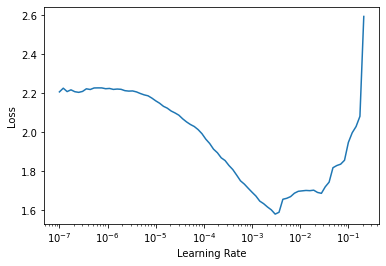

In [9]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.018006,0.778250,0.766644,00:15
1,0.494289,0.340718,0.890185,00:14
2,0.322716,0.317243,0.880577,00:14
3,0.307700,0.402817,0.886754,00:14
4,0.286236,0.380419,0.885381,00:14
5,0.240478,0.388511,0.886067,00:14
6,0.218757,0.281911,0.906658,00:13
7,0.223835,0.549075,0.827728,00:14
8,0.194920,0.752088,0.771448,00:14
9,0.191769,0.226953,0.925189,00:14


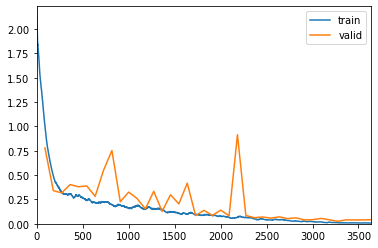

In [10]:
learn.unfreeze()
learn.fit_one_cycle(40, 4e-4)